# lib

In [ ]:
# !pip install Node2Vec
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import SpectralClustering
from scipy.sparse.linalg import eigsh
from scipy.sparse.csgraph import laplacian
import umap
import matplotlib.pyplot as plt
import seaborn as sns

p = pd.read_csv('https://raw.githubusercontent.com/LDpNgn/voz-community-detection/refs/heads/main/dataset/posts.csv', encoding='utf-8')
c = pd.read_csv('https://raw.githubusercontent.com/LDpNgn/voz-community-detection/refs/heads/main/dataset/comments.csv', encoding='utf-8')
u = pd.read_csv('https://raw.githubusercontent.com/LDpNgn/voz-community-detection/refs/heads/main/dataset/users.csv')

In [ ]:
combined_df = pd.merge(p[['post_id', 'title']], c[['post_id', 'comment', 'user_id']], on='post_id', how='left')
combined_df.dropna(inplace=True)
#combined_df

In [ ]:
result = combined_df.groupby("user_id")["comment"].apply(lambda x: " ".join(x)).reset_index()
result = result[result['user_id'].isin(u['id'])]
#result[result['user_id'] == 1736979]

# Function:

### Consensus Matrix Computation

**Input:** The association matrix $ C_{(1)}, C_{(2)}, \ldots, C_{(v)}$ of the social network of $V$ views; the number of communities $k$; initialization parameters $\gamma, \sigma$.

**Output:** A consensus matrix $S$ with $k$ connected components.

1. Initialize the weights $\omega = \frac{1}{V}$ of the connected matrix $C$ for each view of the social network.
2. Initialize the consensus graph matrix $S$ (through $\omega$ and $C$).
3. Use Laplacian Matrix to calculate the matrix $F$.
4. Repeat:
   - Fix $S$, $F$, use adaptive loss function to update $\omega$.
   - Fix $F$, $\omega$, to update $S$.
   - Fix $\omega$, $S$, use Laplacian Matrix to update $F$.
5. Until the relative change in $S$ is less than $ 10^{-3} $ or the number of iterations is greater than 150.
6. Return $S$.

In [ ]:
"""
Algorithm 1: Multi-view community detection based on adaptive loss function (ALMV)

Input:
    The association matrix 𝐶(1),𝐶(2),…,𝐶(𝑣)
    of the social network of V views; the number of communities k; initialization parameters 𝛾, 𝜎

Output:
    A consensus matrix S with k connected components.
"""


# Compute Laplacian matrix
def compute_laplacian(S):
    D = np.diag(S.sum(axis=1))
    L = D - S
    L = (L + L.T) / 2  # Ensure symmetry
    L += np.eye(L.shape[0]) * 1e-6  # Regularize for numerical stability
    return L

# Compute eigenvectors
def compute_eigenvectors(L, k):
    eigvals, eigvecs = eigsh(L, k=k, which='SM')
    return eigvecs

# Update weights based on adaptive loss function
def update_weights(S, C_views, sigma):
    weights = []
    for v in range(len(C_views)):
        diff = np.linalg.norm(C_views[v] - S, 'fro') + 1e-8  # Avoid division by zero
        weight = 1 / (2 * (diff**2 + sigma))
        weights.append(weight)
    weights = np.array(weights) / (np.sum(weights) + 1e-8)  # Normalize weights
    return weights

# Update consensus matrix S
def update_consensus_matrix(F, C_views, weights, sigma, gamma):
    n = C_views[0].shape[0]
    S = np.zeros((n, n))
    for i in range(n):
        # Weighted combination of views
        pi = sum(weights[v] * C_views[v][i] for v in range(len(C_views)))
        S[i] = np.maximum(pi - gamma * np.sum((F[i] - F)**2, axis=1), 0)

        # Handle zero-sum rows explicitly
        row_sum = np.sum(S[i])
        if row_sum == 0:
            S[i] = 1.0 / n  # Reset to uniform distribution
        else:
            S[i] /= row_sum + 1e-8  # Normalize rows
    return S

# Main multi-view community detection function
def multi_view_community_detection(C_views, k, sigma=0.1, gamma=1.0, max_iter=150, tol=1e-3):
    n = C_views[0].shape[0]
    V = len(C_views)
    weights = np.ones(V) / V  # Initialize weights equally
    S = np.mean(C_views, axis=0)  # Initial consensus matrix
    F = compute_eigenvectors(compute_laplacian(S), k)

    for iteration in range(max_iter):
        weights = update_weights(S, C_views, sigma)
        S_new = update_consensus_matrix(F, C_views, weights, sigma, gamma)
        F = compute_eigenvectors(compute_laplacian(S_new), k)

        # Check for convergence
        if np.linalg.norm(S_new - S, 'fro') / (np.linalg.norm(S, 'fro') + 1e-8) < tol:
            print("Convergence achieved.")
            break
        S = S_new

    return S, weights, F

# Visualization using spectral clustering
def spectral_clustering_consensus(S, n_clusters):
    """
    Performs spectral clustering on the consensus matrix.
    """
    affinity_matrix = cosine_similarity(S)

    clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
    labels = clustering.fit_predict(affinity_matrix)
    return labels

In [ ]:
"""
Algorithm 2: Multi-view community analysis method of social networks

Input:
    Social network G; the number of nearest neighbors m; the number of communities k; the initialization parameters 𝛾

Output:
    Visualization results of social network G containing k community structures.
"""


# Step 1: Calculate TF-IDF Matrix
def compute_word_frequencies(data, max_features=None):
    vectorizer = CountVectorizer(max_features=max_features)
    X = vectorizer.fit_transform(data.comment)

    word_freq_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out(), index=data['user_id'])
    return word_freq_df

# key word -> matrix X2
def compute_tfidf(data, max_features=None):
    vectorizer = TfidfVectorizer(max_features=max_features)
    X_tfidf = vectorizer.fit_transform(data.comment)

    tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out(), index=data['user_id'])
    return tfidf_df



# test

In [ ]:
X1 = compute_word_frequencies(result, max_features= 5000)  # word frequency
X2 = compute_tfidf(result, max_features= 5000)

# Construct linkage matrices
C1 = cosine_similarity(X1)
C2 = cosine_similarity(X2)

In [ ]:
C_views = [C1, C2]
for C in C_views:
    np.fill_diagonal(C, 0)  # No self-loops
    C = (C + C.T) / 2

S, weights, F = multi_view_community_detection(C_views, k=4)


Convergence achieved.


In [ ]:
def estimate_k(L):
    eigvals, _ = np.linalg.eigh(L)
    gaps = np.diff(eigvals)
    k = np.argmax(gaps[:10]) + 1  # Chọn khoảng cách lớn nhất
    return k

L = laplacian(S, normed=True)
k = estimate_k(L)
print("Estimated k:", k)

Estimated k: 4


# Spectral Clustering

## 5 cluster

In [ ]:
n = S.shape[0]
num_clusters = 5  # Set the number of clusters (communities)
spectral = SpectralClustering(n_clusters=num_clusters, affinity='precomputed', random_state=42)
labels = spectral.fit_predict(S)

# Step 2: Prepare the Data for Visualization
# Create a DataFrame for visualization
data = pd.DataFrame(labels, columns=['Cluster'], index=result['user_id'])



/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:310: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


In [ ]:
data.value_counts()

,count
Cluster,
0,9141
1,71
4,53
3,20
2,9


## Visualize community

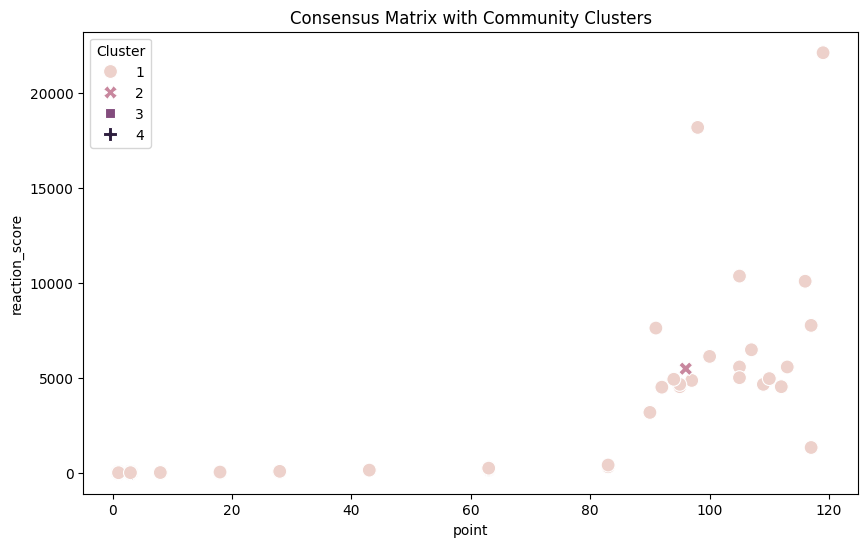

In [ ]:
# Visualize community without label 0

a = pd.merge(u[['id', 'reaction_score', 'point']], data, left_on='id', right_index=True)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=a[a['Cluster'] != 0], x='point', y='reaction_score', hue='Cluster', style='Cluster', s=100)
plt.title('Consensus Matrix with Community Clusters')
plt.xlabel('point')
plt.ylabel('reaction_score')
plt.legend(title='Cluster')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.10/dist-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


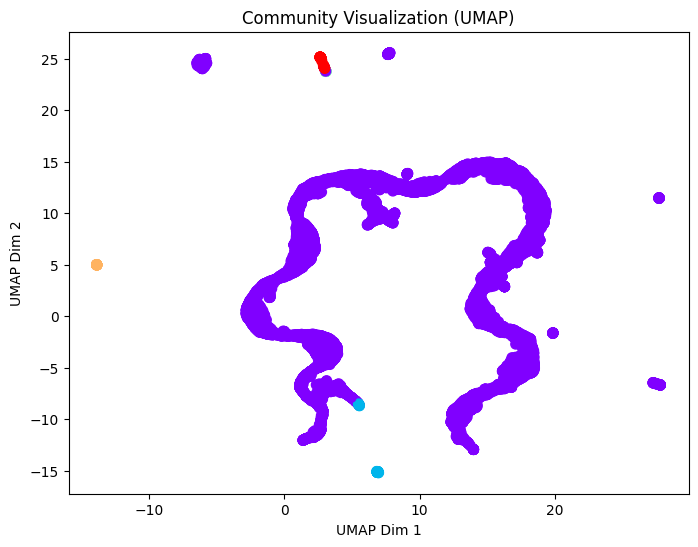

In [ ]:
def visualize_communities_umap(F, labels):
    """
    Visualize communities using UMAP for dimensionality reduction.
    """
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    embeddings_2d = reducer.fit_transform(F)

    plt.figure(figsize=(8, 6))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='rainbow', s=50)
    plt.title("Community Visualization (UMAP)")
    plt.xlabel("UMAP Dim 1")
    plt.ylabel("UMAP Dim 2")
    plt.show()

visualize_communities_umap(F, labels)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


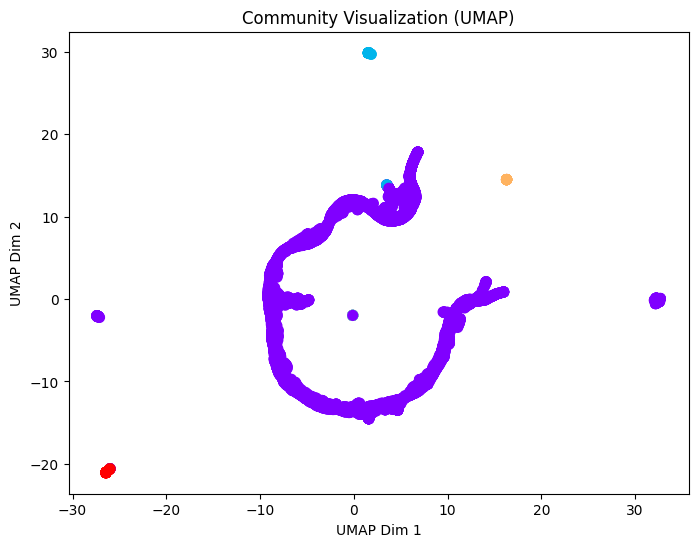

In [ ]:
reducer = umap.UMAP(n_neighbors=50, min_dist=0.1, random_state=42)
embeddings_2d = reducer.fit_transform(F)

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='rainbow', s=50)
plt.title("Community Visualization (UMAP)")
plt.xlabel("UMAP Dim 1")
plt.ylabel("UMAP Dim 2")
plt.show()